# Using SOS for Analysis of Differential Equations 


Consider a differential equation model over $2$ variables. 

$$ \begin{array}{l}
  \frac{dx}{dt} = - 0.2 x^2 - 0.2 x + 0.3 y \\ 
  \frac{dy}{dt} = - 0.1 x - 0.2 y + 0.2 xy \\ 
  \end{array}$$



In [38]:
using Plots
using DifferentialEquations

function ode_system!(du, u, p, t)
     x, y = u
     du[1] = -0.2*x^2 - 0.2*x + 0.3 * y
     du[2] = -0.1 * x - 0.2 * y + 0.2 * x * y
end

function solve_for_init_cond(x0, y0; T=5.0)
     u0 = [x0, y0] # Initial state as a vector
    tspan = (0.0, T) # Time span as a tuple

    prob = ODEProblem(ode_system!, u0, tspan)
    sol = solve(prob)

    x_points = [u[1] for u in sol.u]
    y_points = [u[2] for u in sol.u]
    return (x_points, y_points)

end 

solve_for_init_cond (generic function with 1 method)

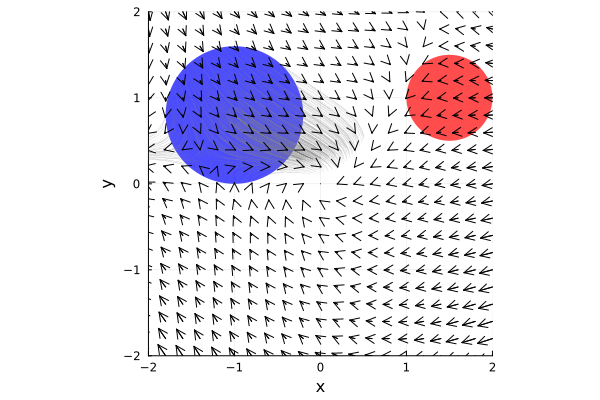

In [39]:
xs = -2.0:0.2:2.0
ys = -2.0:0.2:2.0

dxy_dt(x, y) = [-0.2*x^2 - 0.2*x + 0.3 * y, -0.1 * x - 0.2 * y + 0.2 * x * y]/10.0

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]

# plot unsafe region 

radius = 0.5
center_x = 1.5
center_y = 1.0

# Generate theta values for a smooth circle outline
theta = range(0, stop=2*pi, length=100)

# Calculate x and y coordinates for the circle's perimeter
x_coords = center_x .+ radius .* cos.(theta)
y_coords = center_y .+ radius .* sin.(theta)

# Plot the filled circle using seriestype=:shape
plot(x_coords, y_coords,
     seriestype=:shape,
     aspect_ratio=:equal,  # Ensures the circle is not distorted
     fillalpha=0.7,        # Transparency of the fill
     linealpha=0,          # Make the border invisible
     color=:red,          # Fill color
     legend=false
     )

# plot the initial set
c_init_x = -1.0
c_init_y = 0.8
r_init = 0.8
x_init = c_init_x .+ r_init .* cos.(theta)
y_init = c_init_y .+ r_init .* sin.(theta)

plot!(x_init, y_init,
     seriestype=:shape,
     aspect_ratio=:equal,  # Ensures the circle is not distorted
     fillalpha=0.7,        # Transparency of the fill
     linealpha=0,          # Make the border invisible
     color=:blue,          # Fill color
     xlabel="x",
     ylabel="y",
     legend=false
     )

# plot some solutions 
theta_vals = -π: 0.1: π
r_vals = 0:0.1:r_init
for r in r_vals
    for θ in theta_vals
        (x_t, y_t) = solve_for_init_cond(c_init_x + r*cos(θ), c_init_y + r*sin(θ))
        plot!(x_t, y_t, linewidth=0.1,  color=:gray) 
    end
end

quiver!(xxs, yys, quiver=dxy_dt, color=:black)

plot!(xlim=(-2, 2), ylim=(-2,2))


In [40]:
using DynamicPolynomials
using JuMP
using SumOfSquares
using LinearAlgebra 
using MosekTools 
function compute_barrier(;ϵ = 0.5, λ = 0.5)
    @polyvar x y 
    
    #initialize a solver object 
    solver = optimizer_with_attributes(MosekTools.Optimizer)
    # create a model for sum of squares optimization 
    model = SOSModel(solver)

    # create the monomials -- we will try to find a quartic polynomials
    monos = monomials([x,y], 0:4)
    n_monos = size(monos)[1]
    
    @variable(model, C[1:n_monos]) # create the unknown coefficients 
    # create the barrier form
    B = C ⋅ monos 
    println("Barrier Form: $B")

    # now set up the constraints

    init_set = @set(r_init^2 - (x-c_init_x)^2 - (y-c_init_y)^2 ≥ 0 )
    unsafe_set = @set(0.5^2 - (x-1.5)^2 - (y-1)^2 ≥ 0)

    vectorField = [
        -0.2*x^2 - 0.2*x + 0.3 * y;
        -0.1 * x - 0.2 * y + 0.2 * x * y
        ]
    # first condition: Barrier must be positive over the initial set

    @constraint(model, c1, B ≥ ϵ, domain=init_set)

    # second: Barrier must be negative over the unsafe set
    @constraint(model, c2, B ≤ - ϵ, domain=unsafe_set)

    # third: Barrier must satisfy a decrease condition
    
    # compute the Lie derivative w.r.t the vector field 
    B_diff = differentiate(B, [x, y]) ⋅ vectorField
    @constraint(model, c3, B_diff ≥ - λ * B )
    optimize!(model)
    println(primal_status(model))
    
    println("Found B = $(value(B))")
    
    return (x, y, value(B))

end
    

compute_barrier (generic function with 1 method)

In [41]:
x, y, B = compute_barrier()

Barrier Form: (C[1]) + (C[2])*y + (C[3])*x + (C[4])*y^2 + (C[5])*x*y + (C[6])*x^2 + (C[7])*y^3 + (C[8])*x*y^2 + (C[9])*x^2*y + (C[10])*x^3 + (C[11])*y^4 + (C[12])*x*y^3 + (C[13])*x^2*y^2 + (C[14])*x^3*y + (C[15])*x^4
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 49              
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 15              
  Matrix variables       : 5 (scalarized: 75)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2       

(x, y, 32.62435179198388 + 31.80648263653514y - 60.38786087980549x - 29.56808241279614y² + 31.97701113155869xy - 20.067808383713786x² + 4.334313206298521y³ + 1.444730799099054xy² + 22.777007620030375x²y - 14.909256606532303x³ - 4.334322964891373x²y²)

In [42]:
B_fun(x_val, y_val) = B(x => x_val, y => y_val) # evaluate the barrier 



B_fun (generic function with 1 method)

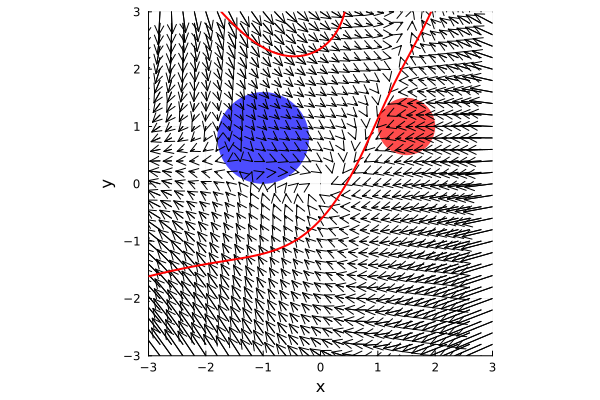

In [43]:
xs = -3.0:0.2:3.0
ys = -3.0:0.2:3.0

dxy_dt(x, y) = [-0.2*x^2 - 0.2*x + 0.3 * y, -0.1 * x - 0.2 * y + 0.2 * x * y]/5.0

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]

# plot unsafe region 

radius = 0.5
center_x = 1.5
center_y = 1.0

# Generate theta values for a smooth circle outline
theta = range(0, stop=2*pi, length=100)

# Calculate x and y coordinates for the circle's perimeter
x_coords = center_x .+ radius .* cos.(theta)
y_coords = center_y .+ radius .* sin.(theta)

# Plot the filled circle using seriestype=:shape
plot(x_coords, y_coords,
     seriestype=:shape,
     aspect_ratio=:equal,  # Ensures the circle is not distorted
     fillalpha=0.7,        # Transparency of the fill
     linealpha=0,          # Make the border invisible
     color=:red,          # Fill color
     legend=false
     )

# plot the initial set
c_init_x = -1.0
c_init_y = 0.8
r_init = 0.8
x_init = c_init_x .+ r_init .* cos.(theta)
y_init = c_init_y .+ r_init .* sin.(theta)

plot!(x_init, y_init,
     seriestype=:shape,
     aspect_ratio=:equal,  # Ensures the circle is not distorted
     fillalpha=0.7,        # Transparency of the fill
     linealpha=0,          # Make the border invisible
     color=:blue,          # Fill color
     xlabel="x",
     ylabel="y",
     legend=false
     )

quiver!(xxs, yys, quiver=dxy_dt, color=:black, arrow_size=0.05)

# plot the Barrier 
x_range = -3.0:0.02:3.0
y_range = -3.0:0.02:3.0

plot!(x_range, y_range, B_fun,
     seriestype=:contour,
     levels=[0],          # Only plot the level where B_fun(x, y) = 0
     colorbar=false,      # Hide the color bar as we're only showing one level
     aspect_ratio=:equal, # Ensures correct aspect ratio for geometric shapes
     linecolor=:red,     # Color of the zero level set line
     linewidth=2          # Thickness of the line
)


plot!(xlim=(-3, 3), ylim=(-3,3))
